<a href="https://colab.research.google.com/github/Judeeme/Real-time-Sleep-Apnoea-Project/blob/main/RF_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend
from scipy.fft import fft, fftfreq

In [ ]:
file_path = '/content/sample_data/10000_17728.edf'

In [ ]:
import mne

# Load EDF file
df_raw = mne.io.read_raw_edf(file_path)

# Print all channels
print(df_raw.info['ch_names'])

Extracting EDF parameters from /content/sample_data/10000_17728.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
['EOG LOC-M2', 'EOG ROC-M1', 'EMG Chin2-Chin1', 'EEG F3-M2', 'EEG F4-M1', 'EEG C3-M2', 'EEG C4-M1', 'EEG O1-M2', 'EEG O2-M1', 'EEG CZ-O1', 'EMG LLeg-RLeg', 'ECG EKG2-EKG', 'Snore', 'Resp PTAF', 'Resp Airflow', 'Resp Thoracic', 'Resp Abdominal', 'SpO2', 'Rate', 'EtCO2', 'Capno', 'Resp Rate', 'C-flow', 'Tidal Vol', 'Pressure']


In [ ]:
spo2 = df_raw.get_data(picks="SpO2")[0]   # SpO₂ signal values
time = df_raw.times                       # time in seconds

print("SpO2 shape:", spo2.shape)

SpO2 shape: (9109504,)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



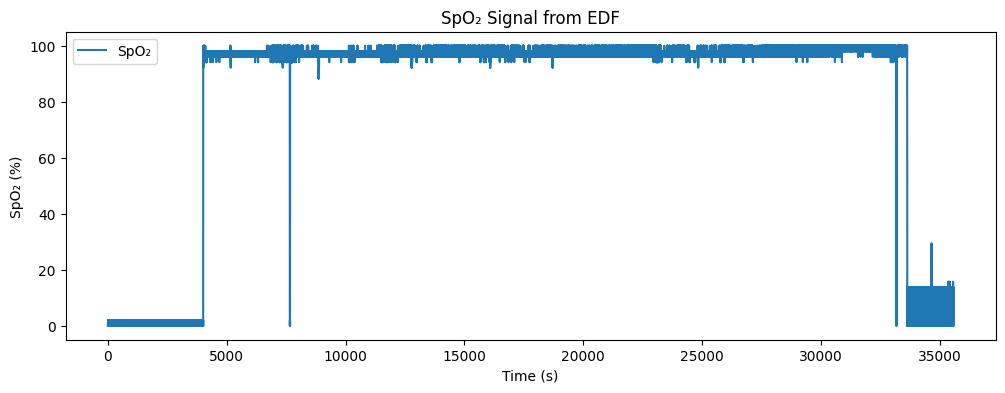

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(time, spo2, label="SpO₂")
plt.xlabel("Time (s)")
plt.ylabel("SpO₂ (%)")
plt.title("SpO₂ Signal from EDF")
plt.legend()
plt.show()

In [ ]:
!pip install plotly --quiet

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=spo2, mode='lines', name='SpO₂'))
fig.update_layout(
    title="Interactive SpO₂ Signal",
    xaxis_title="Time (seconds)",
    yaxis_title="SpO₂ (%)",
    height=400,
)
fig.show()

/tmp/ipython-input-1284224859.py:10: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



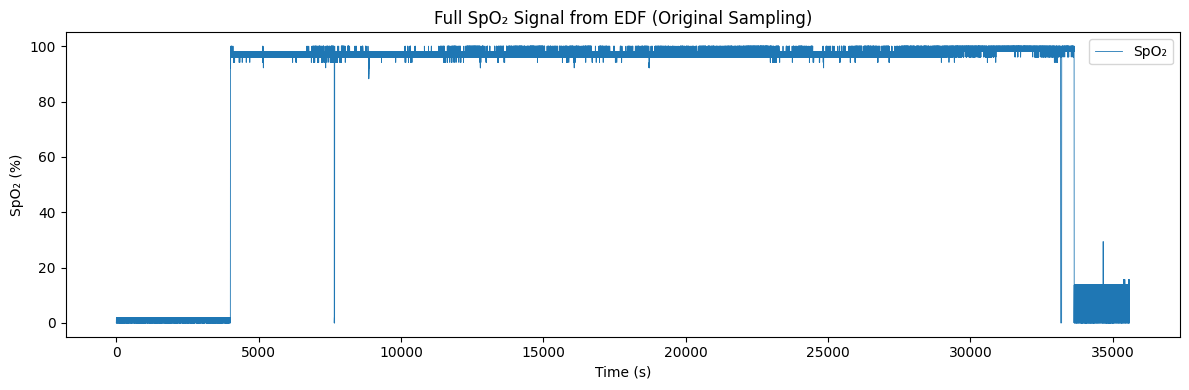

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(time, spo2, label="SpO₂", linewidth=0.6)
plt.xlabel("Time (s)")
plt.ylabel("SpO₂ (%)")
plt.title("Full SpO₂ Signal from EDF (Original Sampling)")
plt.legend()
plt.tight_layout()
plt.show()

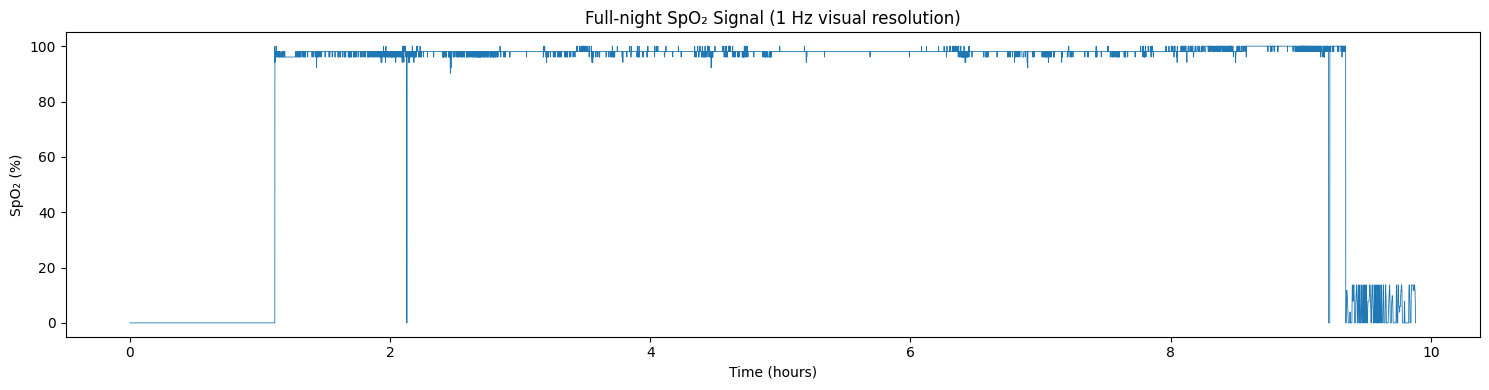

Displayed 35584 points out of 9109504 total.


In [ ]:
# Suppose your sampling rate is fs (e.g., 250 Hz)
fs = df_raw.info['sfreq']   # or set manually if known, e.g. fs = 250

# Calculate decimation factor so you show 1 sample per 1 second
decimation_factor = int(fs)  # 250 → keeps 1 point per second

spo2_decimated = spo2[::decimation_factor]
time_decimated = time[::decimation_factor]

plt.figure(figsize=(15, 4))
plt.plot(time_decimated / 3600, spo2_decimated, linewidth=0.6)
plt.xlabel("Time (hours)")
plt.ylabel("SpO₂ (%)")
plt.title("Full-night SpO₂ Signal (1 Hz visual resolution)")
plt.tight_layout()
plt.show()

print(f"Displayed {len(spo2_decimated)} points out of {len(spo2)} total.")

In [ ]:
# --- 2. Cleaning ---
# Clip to valid physiological range
spo2_clean = np.clip(spo2, 70, 100)

# Replace 0 with NaN and interpolate
spo2_clean = pd.Series(spo2_clean).replace(0, np.nan).interpolate()

# Smooth with Savitzky-Golay
from scipy.signal import savgol_filter
spo2_clean = savgol_filter(spo2_clean, window_length=11, polyorder=2)

# --- 3. Put into DataFrame & Resample to 1 Hz ---
df_spo2 = pd.DataFrame({"Time": time, "SpO2": spo2, "SpO2_clean": spo2_clean})

# Convert seconds to datetime for resampling
df_spo2["Timestamp"] = pd.to_timedelta(df_spo2["Time"], unit="s")
df_spo2 = df_spo2.set_index("Timestamp").resample("1s").mean().interpolate()

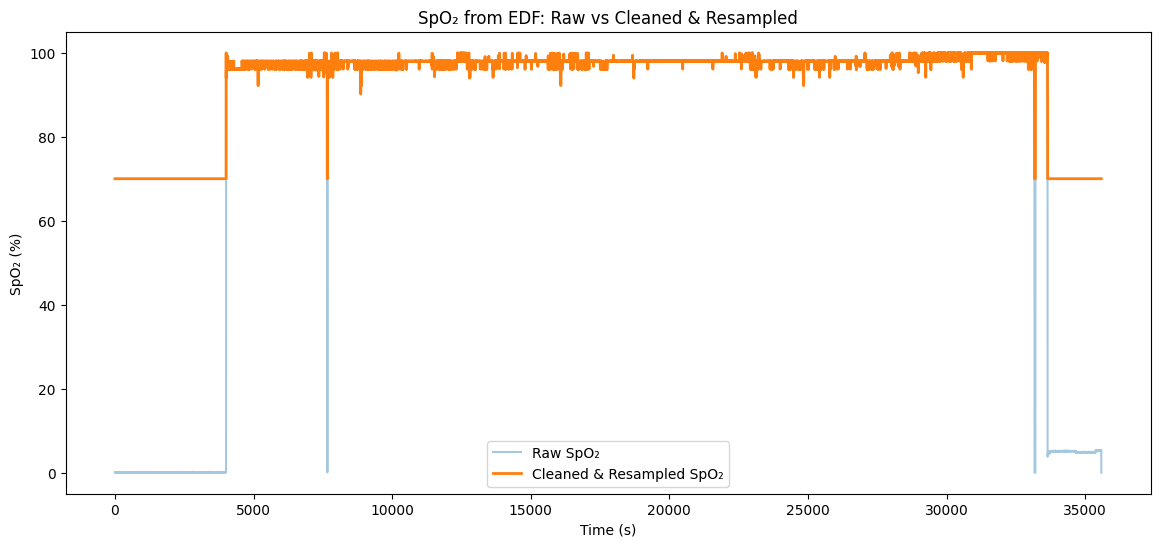

In [ ]:
# --- 4. Plot raw vs cleaned ---
plt.figure(figsize=(14,6))
plt.plot(df_spo2.index.total_seconds(), df_spo2["SpO2"], label="Raw SpO₂", alpha=0.4)
plt.plot(df_spo2.index.total_seconds(), df_spo2["SpO2_clean"], label="Cleaned & Resampled SpO₂", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("SpO₂ (%)")
plt.title("SpO₂ from EDF: Raw vs Cleaned & Resampled")
plt.legend()
plt.show()

In [ ]:
# --- 4. Save to CSV ---
import os

output_path = "/content/drive/MyDrive/Colab Notebooks/OSA/spo2_cleaned_resampled.csv"

# Create the directory if it doesn't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_spo2.to_csv(output_path)

print(f"✅ Cleaned & resampled SpO₂ saved to: {output_path}")

✅ Cleaned & resampled SpO₂ saved to: /content/drive/MyDrive/Colab Notebooks/OSA/spo2_cleaned_resampled.csv


In [ ]:
# --- 4. Detect Desaturation Events ---
threshold_drop = 3   # ≥3% drop
min_duration = 8     # at least 8 seconds
baseline_window_seconds = 120  # Look back 2 minutes for a stable baseline

events = []
in_event = False
event_start = None
event_nadir = None  # Track the lowest point

# Convert the index to seconds for easier calculation
time_in_seconds = df_spo2.index.total_seconds()
spo2_values = df_spo2["SpO2_clean"].values

for i in range(len(df_spo2)):
    current_time = time_in_seconds[i]
    current_spo2 = spo2_values[i]

    # Calculate the baseline: median of the previous 2 minutes
    # Find indices of data points within the baseline window
    baseline_mask = (time_in_seconds >= (current_time - baseline_window_seconds)) & (time_in_seconds < current_time)

    if np.any(baseline_mask):
        baseline_value = np.median(spo2_values[baseline_mask])
    else:
        baseline_value = current_spo2  # Fallback for beginning of recording

    if not in_event:
        # Check if current SpO2 drops below baseline - threshold
        if current_spo2 < (baseline_value - threshold_drop):
            in_event = True
            event_start = df_spo2.index[i]
            event_nadir = current_spo2  # Initialize nadir
            event_baseline = baseline_value # Lock the baseline for this event
    else:
        # We are in an event. Update the nadir.
        if current_spo2 < event_nadir:
            event_nadir = current_spo2

        # Check if we have recovered above the recovery threshold
        # Often uses a value higher than the start threshold to avoid flickering (e.g., 2%)
        recovery_threshold = event_baseline - (threshold_drop * 0.66) # e.g., 2% for a 3% drop
        if current_spo2 >= recovery_threshold:
            event_end = df_spo2.index[i]
            duration = (event_end - event_start).total_seconds()

            if duration >= min_duration:
                # Calculate the total drop from the locked baseline
                total_drop = event_baseline - event_nadir
                events.append({
                    "Start": event_start,
                    "End": event_end,
                    "Duration": duration,
                    "Baseline_SpO2": event_baseline,
                    "Nadir_SpO2": event_nadir,
                    "Drop_Percent": total_drop
                })
            # Reset for next event
            in_event = False
            event_start = None
            event_nadir = None

events_df = pd.DataFrame(events)

# --- 5. Compute ODI ---
if not df_spo2.empty:
    total_hours = (df_spo2.index[-1] - df_spo2.index[0]).total_seconds() / 3600
    if total_hours > 0:
        odi = len(events_df) / total_hours
        print(f"ODI (≥{threshold_drop}% desats per hour): {odi:.2f}")
    else:
        print("Recording duration is too short to calculate ODI.")
else:
    print("DataFrame is empty.")

# --- 6. Save Data ---
events_df.to_csv("/content/drive/MyDrive/Colab Notebooks/OSA/spo2_desaturation_events.csv", index=False)

ODI (≥3% desats per hour): 0.61


In [ ]:
# Read the file
annot_file ="/content/sample_data/10000_17728.annot"
with open(annot_file, 'r') as f:
    for i, line in enumerate(f):
        if i == 3: # Line 4 (0-indexed)
            print(f"Line 4: {line}")
            break

Line 4: Recording Analyzer - ECG	1.1640625	+0.0



In [ ]:
annot_file = "/content/sample_data/10000_17728.annot"

# Read the first few lines to understand the structure
num_lines_to_read = 30
with open(annot_file, 'r') as f:
    for i in range(num_lines_to_read):
        line = f.readline()
        print(f"Line {i+1}: {line.strip()}")

# Read the first few lines to understand the structure
num_lines_to_read = 30
with open(annot_file, 'r') as f:
    for i in range(num_lines_to_read):
        line = f.readline()
        print(f"Line {i+1}: {line.strip()}")

Line 1: Montage_NCH_PSG_STANDARD, Ref	1.03515625	+0.0
Line 2: Start Recording	1.03515625	+0.0
Line 3: Montage_NCH_PSG_STANDARD, Ref	1.03515625	+0.0
Line 4: Recording Analyzer - ECG	1.1640625	+0.0
Line 5: Video Recording ON	1.6171875	+0.0
Line 6: Montage_Channel Test Referential	56.78125	+0.0
Line 7: Montage_Channel Test Referential	56.78125	+0.0
Line 8: Montage_NCH_PSG_STANDARD	117.109375	+0.0
Line 9: Montage_NCH_PSG_STANDARD	117.109375	+0.0
Line 10: Impedance at 5 kOhm	2801.015625	+0.0
Line 11: Impedance at 5 kOhm	3150.890625	+0.0
Line 12: left foot stim	3950.5859375	+0.0
Line 13: right foot stim	3958.57421875	+0.0
Line 14: eyes closed	3964.08203125	+0.0
Line 15: eyes open	3972.16796875	+0.0
Line 16: Sleep stage W	4080.9609375	+30.0
Line 17: Lights Off	4087.16796875	+0.0
Line 18: Sleep stage N1	4110.9609375	+30.0
Line 19: Sleep stage N2	4140.9609375	+30.0
Line 20: sleep onset	4141.2890625	+0.0
Line 21: Sleep stage N2	4170.9609375	+30.0
Line 22: Body Position_ Supine	4200.19140625	+0.0

In [ ]:
tsv_file = "/content/sample_data/10000_17728.tsv"

In [44]:
print("\nDataframe info:")
print(annotations_tsv.info())


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   onset        1502 non-null   float64
 1   duration     1502 non-null   float64
 2   description  1502 non-null   object 
dtypes: float64(2), object(1)
memory usage: 35.3+ KB
None


In [ ]:
# Read the TSV file into a pandas DataFrame
annotations_tsv = pd.read_csv(tsv_file, sep='\t')

# Now you can print the info
print("\nDataframe info:")
print(annotations_tsv.info())


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   onset        1502 non-null   float64
 1   duration     1502 non-null   float64
 2   description  1502 non-null   object 
dtypes: float64(2), object(1)
memory usage: 35.3+ KB
None


In [ ]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, medfilt

# 1. GET THE APNEA EVENTS
apnea_events = annotations_tsv[
    annotations_tsv['description'].str.contains('apnea|hypopnea', case=False, na=False)
].copy()
apnea_events['start_sec'] = apnea_events['onset']
apnea_events['end_sec'] = apnea_events['onset'] + apnea_events['duration']

print(f"Found {len(apnea_events)} apnea/hypopnea events")
print("\nFirst few apnea events:")
print(apnea_events[['onset', 'duration', 'description', 'start_sec', 'end_sec']].head()) # Include new columns in print

# Get SpO2 channel name and data correctly
try:
    spo2_ch_name = [name for name in df_raw.ch_names if 'spo' in name.lower() or 'oxy' in name.lower()][0]
    spo2_data = df_raw.get_data(picks=spo2_ch_name)[0] # Use get_data and take the first row for the channel
    spo2_times = df_raw.times # Get all times

    print(f"\nSuccessfully extracted data for channel: {spo2_ch_name}")
    print(f"SpO2 data shape: {spo2_data.shape}")
    print(f"SpO2 times shape: {spo2_times.shape}")

except IndexError:
    print("\nError: No SpO2 channel found.")
    spo2_data = np.array([]) # Assign empty array to avoid further errors
    spo2_times = np.array([])
except Exception as e:
    print(f"\nError extracting SpO2 data: {e}")
    spo2_data = np.array([])
    spo2_times = np.array([])


# Create apnea mask aligned with SpO₂ timeline using the correct spo2_times
apnea_mask = np.zeros_like(spo2_times)
# Iterate over rows of the DataFrame
for index, event in apnea_events.iterrows():
    apnea_mask[(spo2_times >= event["start_sec"]) & (spo2_times <= event["end_sec"])] = 1 # Use 'start_sec' and 'end_sec'


# Remove unrealistic values and smooth noise (using medfilt as in user's cell)
if spo2_data.size > 0:
    spo2_data_cleaned = np.clip(spo2_data, 70, 100)  # physiological range
    # Use a kernel size that is odd and smaller than the data size
    kernel_size = 5
    if len(spo2_data_cleaned) >= kernel_size:
        spo2_data_smoothed = medfilt(spo2_data_cleaned, kernel_size=kernel_size)
    else:
        print(f"Warning: Data length ({len(spo2_data_cleaned)}) is less than kernel size ({kernel_size}). Skipping medfilt.")
        spo2_data_smoothed = spo2_data_cleaned # Keep original if cannot smooth
else:
    spo2_data_smoothed = np.array([])


# Downsample to 1 Hz for efficiency
fs = df_raw.info['sfreq']
if spo2_data_smoothed.size > 0:
    factor = int(fs)
    # Ensure factor is not zero or negative
    if factor <= 0:
        print(f"Warning: Sampling frequency ({fs}) results in non-positive downsampling factor. Skipping downsampling.")
        spo2_ds = spo2_data_smoothed
        time_ds = spo2_times
        apnea_mask_ds = apnea_mask
    else:
        spo2_ds = spo2_data_smoothed[::factor]
        time_ds = spo2_times[::factor]
        apnea_mask_ds = apnea_mask[::factor]
        print(f"Downsampled from {len(spo2_data_smoothed)} → {len(spo2_ds)} points")
else:
    spo2_ds = np.array([])
    time_ds = np.array([])
    apnea_mask_ds = np.array([])
    print("No data to downsample.")


# =============================================
# 5. Feature Extraction
# =============================================
# We'll use a sliding window to compute features over time
window_size = 30  # seconds
step = 10  # seconds
samples_per_window = int(window_size)
step_size = int(step)

features = []
labels = []

# Ensure there is enough data for at least one window
if len(spo2_ds) >= samples_per_window:
    for start in range(0, len(spo2_ds) - samples_per_window + 1, step_size): # Added +1 to include the last possible window
        end = start + samples_per_window
        segment = spo2_ds[start:end]
        # Explicitly cast boolean to int
        label = int(np.mean(apnea_mask_ds[start:end]) > 0.5)

        mean_val = np.mean(segment)
        std_val = np.std(segment)
        min_val = np.min(segment)
        max_val = np.max(segment)
        range_val = max_val - min_val
        drop_val = mean_val - min_val
        # Avoid division by zero if window_size is 0, though it's set to 30
        slope = (segment[-1] - segment[0]) / window_size if window_size > 0 else 0

        features.append([mean_val, std_val, min_val, max_val, range_val, drop_val, slope])
        labels.append(label)

    feature_names = ["mean", "std", "min", "max", "range", "drop", "slope"]
    X = np.array(features)
    y = np.array(labels)

    print(f"Feature matrix shape: {X.shape}, Labels: {np.bincount(y)}")

else:
    print(f"Not enough data points ({len(spo2_ds)}) for a window size of {samples_per_window}. Skipping feature extraction.")
    X = np.array([])
    y = np.array([])

# The plotting and summary analysis sections from the original cell are removed
# as they were causing display issues and are not directly related to the feature extraction error.
# These can be added back in separate cells if needed.

Found 6 apnea/hypopnea events

First few apnea events:
            onset   duration        description     start_sec       end_sec
235   8840.085938  13.593750      Central Apnea   8840.085938   8853.679688
291  10320.210938  12.000000           Hypopnea  10320.210938  10332.210938
293  10339.429688  18.656250      Central Apnea  10339.429688  10358.085938
332  11486.492188  13.062500  Obstructive Apnea  11486.492188  11499.554688
355  12036.632812  18.421875  Obstructive Apnea  12036.632812  12055.054688

Successfully extracted data for channel: SpO2
SpO2 data shape: (9109504,)
SpO2 times shape: (9109504,)
Downsampled from 9109504 → 35584 points
Feature matrix shape: (3556, 7), Labels: [3550    6]


In [ ]:
apnea_events = []
for onset, duration, desc in zip(annotations_tsv.onset, annotations_tsv.duration, annotations_tsv.description):
    if "apnea" in desc.lower() or "hypopnea" in desc.lower():
        apnea_events.append({"start": onset, "end": onset + duration, "label": desc})
print(f"Detected {len(apnea_events)} apnea/hypopnea events")

Detected 6 apnea/hypopnea events


In [ ]:
# Create apnea mask aligned with SpO₂ timeline
apnea_mask = np.zeros_like(time)
for event in apnea_events:
    apnea_mask[(time >= event["start"]) & (time <= event["end"])] = 1

In [ ]:
# Remove unrealistic values and smooth noise
from scipy.signal import medfilt
spo2_data = np.clip(spo2_data, 70, 100)  # physiological range
spo2_data = medfilt(spo2_data, kernel_size=5)

/tmp/ipython-input-955200696.py:4: UserWarning:

kernel_size exceeds volume extent: the volume will be zero-padded.



In [ ]:
# downsample to 1 Hz for efficiency
factor = int(fs)
spo2_ds = spo2_data[::factor]
time_ds = time[::factor]
apnea_mask_ds = apnea_mask[::factor]

print(f"Downsampled from {len(spo2_data)} → {len(spo2_ds)} points")

Downsampled from 1 → 1 points


In [ ]:
# =============================================
# 5. Feature Extraction
# =============================================
# We'll use a sliding window to compute features over time
window_size = 30  # seconds
step = 10  # seconds
samples_per_window = int(window_size)
step_size = int(step)

features = []
labels = []

for start in range(0, len(spo2_ds) - samples_per_window, step_size):
    end = start + samples_per_window
    segment = spo2_ds[start:end]
    label = int(np.mean(apnea_mask_ds[start:end]) > 0.5)

    mean_val = np.mean(segment)
    std_val = np.std(segment)
    min_val = np.min(segment)
    max_val = np.max(segment)
    range_val = max_val - min_val
    drop_val = mean_val - min_val
    slope = (segment[-1] - segment[0]) / window_size

    features.append([mean_val, std_val, min_val, max_val, range_val, drop_val, slope])
    labels.append(label)

feature_names = ["mean", "std", "min", "max", "range", "drop", "slope"]
X = np.array(features)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}, Labels: {np.bincount(y)}")

Feature matrix shape: (3556, 7), Labels: [3550    6]


In [ ]:
# 6. Train Random Forest Classifier
# =============================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model (optional, but good practice)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9985955056179775
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       711
           1       0.00      0.00      0.00         1

    accuracy                           1.00       712
   macro avg       0.50      0.50      0.50       712
weighted avg       1.00      1.00      1.00       712



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# 7. Evaluate Model
# =============================================
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report # Import confusion_matrix

print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Apnea"]))


Model Performance:
Accuracy: 0.999
Confusion Matrix:
[[711   0]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       711
       Apnea       0.00      0.00      0.00         1

    accuracy                           1.00       712
   macro avg       0.50      0.50      0.50       712
weighted avg       1.00      1.00      1.00       712



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



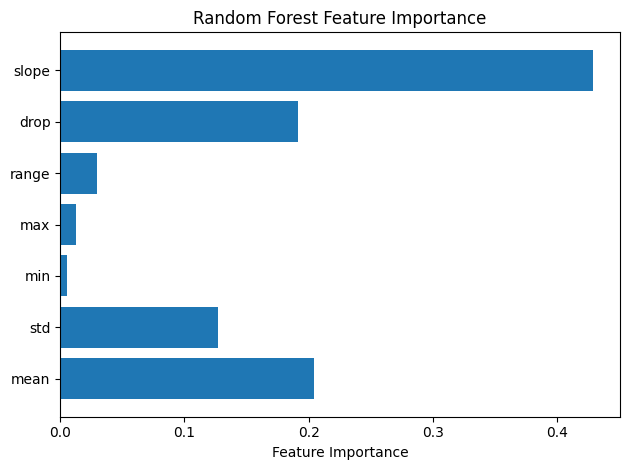

In [ ]:
# Feature Importance Visualization
# =============================================
importances = clf.feature_importances_
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
# Save Results
# =============================================
results = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
results.to_csv("feature_importance_spo2_apnea.csv", index=False)

print("✅ Random Forest training complete! Results saved to 'feature_importance_spo2_apnea.csv'.")

✅ Random Forest training complete! Results saved to 'feature_importance_spo2_apnea.csv'.
